In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [158]:
df = pd.read_csv('image_processing_results.csv')

df = df.rename(columns={df.columns[0]: 'image', df.columns[1]: 'type', df.columns[2]: 'kernel_size', df.columns[3]: 'time'})

df_transformations = df[df['kernel_size'] == 0]
df_filters = df[df['kernel_size'] != 0]

In [159]:
df_transformations

,image,type,kernel_size,time
360,23,rotate,0,0.119129
361,23,schear,0,0.117966
362,17,rotate,0,0.117654
363,17,schear,0,0.117930
364,20,rotate,0,0.118013
...,...,...,...,...
73435,13,schear,0,0.569908
73436,15,rotate,0,0.856976
73437,15,schear,0,0.749106
73438,7,rotate,0,0.733853


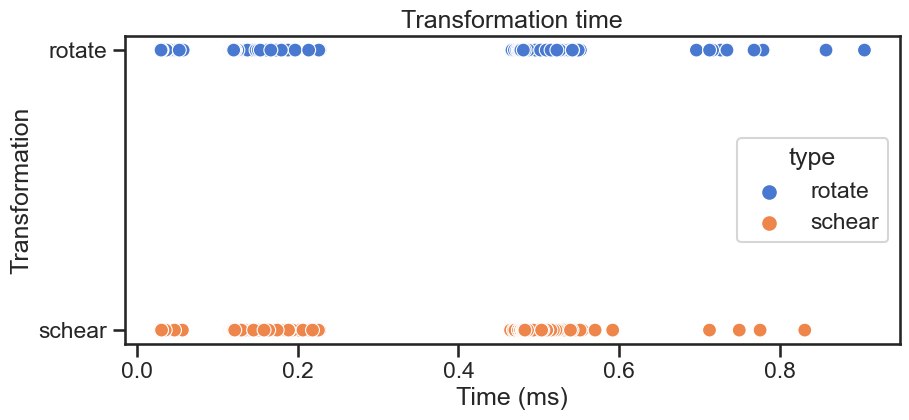

In [160]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df_transformations, x='time', y='type', hue='type', s=100)
plt.title('Transformation time')
plt.ylabel('Transformation')
plt.xlabel('Time (ms)')
plt.savefig('transformation_time.png', dpi=300)
plt.show()


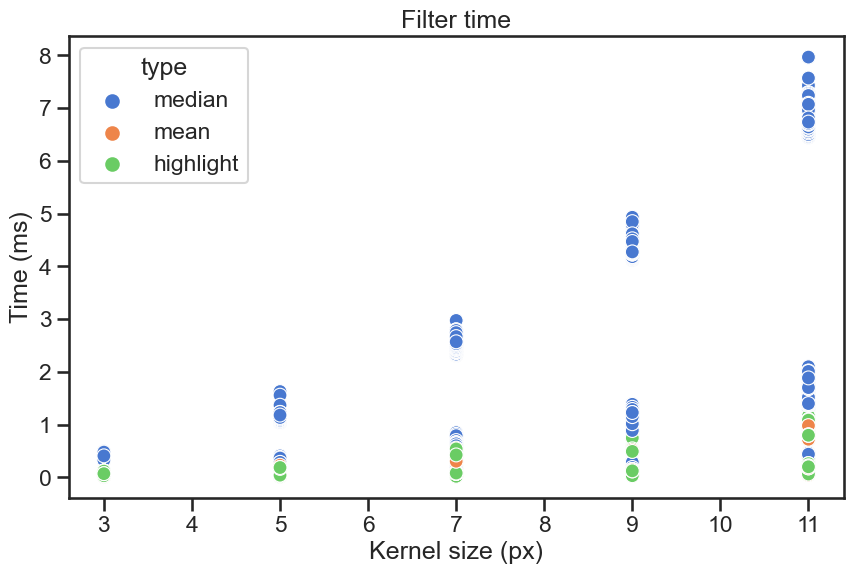

In [161]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filters, x='kernel_size', y='time', hue='type', s=100)
plt.title('Filter time')
plt.xlabel('Kernel size (px)')
plt.ylabel('Time (ms)')
plt.savefig('filter_time.png', dpi=300)
plt.show()

In [162]:
df_batch = pd.read_csv('batch_processing_results.csv')
df_batch = df_batch.drop(columns=['image', 'type', 'kernel_size'])
df_batch

,time
0,144.3070
1,144.2770
2,144.1220
3,144.7980
4,144.0870
...,...
175,65.0282
176,65.4023
177,67.5919
178,66.0926


In [163]:
import numpy as np

np = np.repeat([1, 2, 3, 4, 5, 6], 30)[:180]
df_batch['np'] = np
df_batch
    

,time,np
0,144.3070,1
1,144.2770,1
2,144.1220,1
3,144.7980,1
4,144.0870,1
...,...,...
175,65.0282,6
176,65.4023,6
177,67.5919,6
178,66.0926,6


In [164]:
df_batch.to_csv('batch_processing_results_processed.csv', index=False)

In [170]:
df_mean = df_batch.groupby(['np', 'ci_lower', 'ci_upper']).mean()
df_mean = df_mean.reset_index()
df_mean

,np,ci_lower,ci_upper,time
0,1,144.267299,144.399568,144.333433
1,2,98.223187,98.333120,98.278153
2,3,80.390509,80.516098,80.453303
3,4,72.215787,72.389513,72.302650
4,5,63.898658,64.142996,64.020827
5,6,65.798579,66.333221,66.065900


/var/folders/t8/zdrd9l7d6sn0d3v91qpznmp00000gn/T/ipykernel_28017/3316814449.py:30: UserWarning: 
The markers list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(


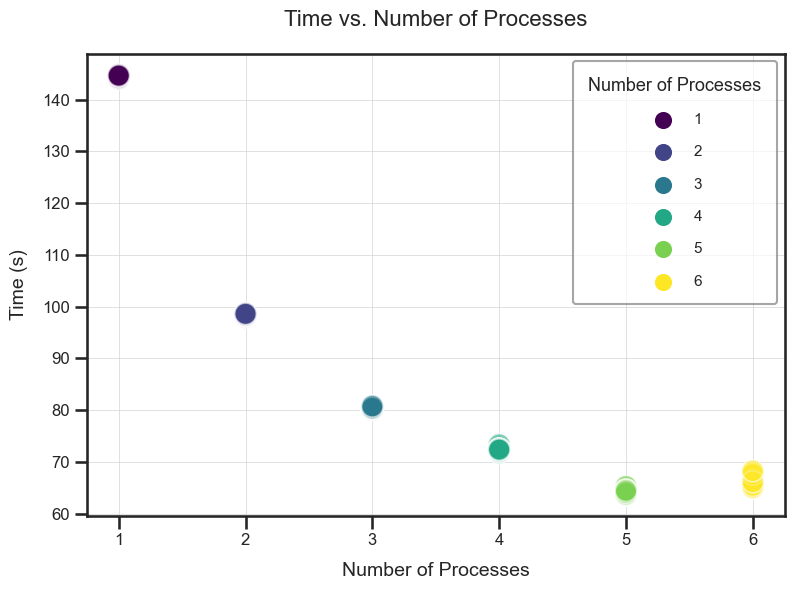

In [166]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_confidence_interval(df, confidence_level=0.95):
    mean = df.mean()
    std = df.std()
    n = len(df)
    z = norm.ppf(confidence_level)
    ci = z * (std / np.sqrt(n))
    return mean - ci, mean + ci

confidence_interval = df_batch.groupby('np')['time'].apply(lambda x: calculate_confidence_interval(x, 0.95)).apply(pd.Series).reset_index()
confidence_interval.columns = ['np', 'ci_lower', 'ci_upper']

for i in range(1, 7):
    df_batch.loc[df_batch['np'] == i, 'ci_lower'] = confidence_interval.loc[confidence_interval['np'] == i, 'ci_lower'].values[0]
    df_batch.loc[df_batch['np'] == i, 'ci_upper'] = confidence_interval.loc[confidence_interval['np'] == i, 'ci_upper'].values[0]



# Set an elegant theme
sns.set_theme(style='ticks', context='talk', palette='muted')

# Create a larger, more proportionate figure
plt.figure(figsize=(9, 6))

# Create a scatter plot with improved aesthetics
scatter = sns.scatterplot(
    x='np', 
    y='time', 
    data=df_batch, 
    hue='np', 
    palette='viridis',
    style='np',  # Differentiate by style as well as color
    markers='o',  # Use a different marker for a fresh look
    s=250,  # Slightly larger markers
    alpha=0.6  # A bit more transparency for overlapping points
)

# for i in df_mean['np'].unique():
#     subset = df_mean[df_mean['np'] == i]
#     plt.errorbar(
#         x=subset['np'], 
#         y=subset['time'],
#         yerr=[abs(subset['time'] - subset['ci_lower']), abs(subset['ci_upper'] - subset['time'])],
#         fmt='none',  # No center marker
#         capsize=5,  # Caps on the error bars
#         ecolor='red',  # Color of the error bars
#         elinewidth=2,  # Width of the error bars
#         capthick=1,  # Thickness of the caps
#         label='95% CI' if i == 1 else None  # Only label one set of error bars
#     )

# handles, labels = scatter.get_legend_handles_labels()

# # Add custom legend entry for sample size
# sample_size_handle = plt.Line2D([], [], color='gray', marker='o', linestyle='None', 
#                                 markersize=8, label='Sample size: 30')

# # Append the custom legend entry
# handles.append(sample_size_handle)

# Enhance the legend
leg = plt.legend(
    # handles=handles,
    title='Number of Processes', 
    title_fontsize='13', 
    fontsize='11', 
    loc='upper right',  # Changed to upper right corner
    frameon=True,  # Optionally add a frame
    framealpha=0.7,  # Slight transparency in the frame
    edgecolor='gray',  # Frame edge color
    labelspacing=1.2, 
    handletextpad=1, 
    borderpad=1, 
    markerscale=1.2
)

# Update labels and title with improved styling
plt.xlabel('Number of Processes', fontsize=14, labelpad=10)
plt.ylabel('Time (s)', fontsize=14, labelpad=10)
plt.title('Time vs. Number of Processes', fontsize=16, pad=20)

# Refine gridlines and ticks
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgrey')
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the plot with high resolution
plt.savefig('times_scatter.png', dpi=300, bbox_inches='tight')



In [171]:
df_mean

,np,ci_lower,ci_upper,time
0,1,144.267299,144.399568,144.333433
1,2,98.223187,98.333120,98.278153
2,3,80.390509,80.516098,80.453303
3,4,72.215787,72.389513,72.302650
4,5,63.898658,64.142996,64.020827
5,6,65.798579,66.333221,66.065900


In [177]:
df_stats = df_batch.groupby('np')['time'].agg(['mean', 'std', 'max', 'min'])
df_stats = df_stats.reset_index()
df_stats['CI'] = list(zip(round(df_mean['ci_lower'],3), round(df_mean['ci_upper'],3)))
df_stats = round(df_stats, 3)
df_stats = df_stats.transpose()
df_stats


,0,1,2,3,4,5
np,1,2,3,4,5,6
mean,144.333,98.278,80.453,72.303,64.021,66.066
std,0.22,0.183,0.209,0.289,0.407,0.89
max,144.804,98.683,80.816,73.306,65.249,68.254
min,144.04,97.881,79.99,71.711,63.629,64.944
CI,"(144.267, 144.4)","(98.223, 98.333)","(80.391, 80.516)","(72.216, 72.39)","(63.899, 64.143)","(65.799, 66.333)"
